# IMPORT

In [1]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu110/torch1.7.0/index.html
!pip install mmsegmentation
!pip install nb
import mmseg
import os
import mmcv
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image

from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

from mmcv import Config


from mmseg.apis import set_random_seed
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

Looking in links: https://download.openmmlab.com/mmcv/dist/cu110/torch1.7.0/index.html
     |████████████████████████████████| 51.2 MB 10.3 MB/s 
     |████████████████████████████████| 185 kB 4.4 MB/s 
     |████████████████████████████████| 630 kB 4.5 MB/s 
  Created wheel for nb: filename=nb-0.1.2-py3-none-any.whl size=5360 sha256=2ee498d04a57bec2d2557ecc73de030bb63b345e312aec82ace9d1b9c972ed24
  Stored in directory: /root/.cache/pip/wheels/ca/86/8a/72cf43e8f67171697d15f17620d1896939bb6c7acaaa5e8a19
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13724 sha256=7743a6eeb2c4a2afaf1c789ef66cd4a011b38a92feb43865875407f723600fa0
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built nb docopt


# DATASET

In [2]:
classes = ('non-building', 'building')
palette = [[128, 128, 128], [196, 128, 224]]

@DATASETS.register_module()
class MlCourseData(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

# CHECKPOINTS

In [3]:
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
    
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/swin/upernet_swin_base_patch4_window12_512x512_160k_ade20k_pretrain_384x384_22K/upernet_swin_base_patch4_window12_512x512_160k_ade20k_pretrain_384x384_22K_20210531_125459-429057bf.pth ./checkpoints

# COMFIG

In [4]:
src_path = '../input/mmseg0/mmsegmentation-master/'
config_file = src_path + '/configs/swin/upernet_swin_base_patch4_window12_512x512_160k_ade20k_pretrain_384x384_22K.py'
check_point_file = '../input/mmsegoutput/work_dirs/demo/iter_15000.pth'
cfg = Config.fromfile(config_file)
data_root = '../input/mlcourse/data/my_dataset'
img_dir = 'img_dir'
ann_dir = 'ann_dir'

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

cfg.model.decode_head.loss_decode=dict(
            type='LovaszLoss', reduction='none', loss_weight=1.0)
cfg.model.auxiliary_head.loss_decode=dict(
            type='LovaszLoss', reduction='none', loss_weight=0.4)

cfg.model.decode_head.sampler=dict(type='OHEMPixelSampler', thresh=0.95, min_kept=100000)
cfg.model.auxiliary_head.sampler=dict(type='OHEMPixelSampler', thresh=0.95, min_kept=100000)

cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

# Modify dataset type and path
cfg.dataset_type = 'MlCourseData'
cfg.data_root = data_root

cfg.img_norm_cfg = dict(
    mean=[110.909, 110.884, 110.873], std=[46.329, 46.208, 46.209], to_rgb=True)

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu=2
cfg.img_scale = (512, 512)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
#     dict(type='Resize', img_scale=cfg.img_scale, ratio_range=(0.75, 1.25)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
#     dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[110.909, 110.884, 110.873], std=[46.329, 46.208, 46.209], to_rgb=True),
#     dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
            img_scale=(512, 512),
            img_ratios=[1.0, 1.0],
            flip=True,
            transforms=[
                dict(type='Resize', keep_ratio=True),
                dict(type='RandomFlip'),
                dict(type='Normalize', **cfg.img_norm_cfg),
                dict(type='Pad', size_divisor=32),
                dict(type='ImageToTensor', keys=['img']),
                dict(type='Collect', keys=['img']),
])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = '../input/mlcoursetest/testdata'
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = None
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '../input/mlcoursetest/testdata/splits/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = check_point_file

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/demo'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = cfg.runner.max_iters
cfg.evaluation.metric=['mIoU','mDice']
cfg.checkpoint_config.interval = cfg.runner.max_iters

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/swin_base_patch4_window12_384_22k.pth',
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=384,
        embed_dims=128,
        patch_size=4,
        window_size=12,
        mlp_ratio=4,
        depths=[2, 2, 18, 2],
        num_heads=[4, 8, 16, 32],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        use_abs_pos_embed=False,
        act_cfg=dict(type='GELU'),
        norm_cfg=dict(type='LN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[128, 256, 512, 1024],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=512,
        dropout_ratio=0.1,
     

# TRAIN & VAL

In [5]:
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict(CLASSES=model.CLASSES,PALETTE=palette))

2021-12-03 13:43:01,637 - mmseg - INFO - Loaded 4848 images
/opt/conda/lib/python3.7/site-packages/mmseg/models/backbones/swin.py:553: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2021-12-03 13:43:08,811 - mmseg - INFO - Loaded 924 images
2021-12-03 13:43:08,813 - mmseg - INFO - load checkpoint from local path: ../input/mmsegoutput/work_dirs/demo/iter_15000.pth
2021-12-03 13:43:20,297 - mmseg - INFO - Start running, host: root@55bc21ba477c, work_dir: /kaggle/working/work_dirs/demo
2021-12-03 13:43:20,298 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW   

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 924/924, 2.4 task/s, elapsed: 383s, ETA:     0s

2021-12-03 17:23:04,143 - mmseg - INFO - per class results:
2021-12-03 17:23:04,145 - mmseg - INFO - 
+--------------+-------+-------+-------+
|    Class     |  IoU  |  Acc  |  Dice |
+--------------+-------+-------+-------+
| non-building | 98.46 | 99.29 | 99.23 |
|   building   | 92.81 | 95.95 | 96.27 |
+--------------+-------+-------+-------+
2021-12-03 17:23:04,146 - mmseg - INFO - Summary:
2021-12-03 17:23:04,148 - mmseg - INFO - 
+-------+-------+-------+-------+
|  aAcc |  mIoU |  mAcc | mDice |
+-------+-------+-------+-------+
| 98.72 | 95.64 | 97.62 | 97.75 |
+-------+-------+-------+-------+
2021-12-03 17:23:04,153 - mmseg - INFO - Iter(val) [924]	aAcc: 0.9872, mIoU: 0.9564, mAcc: 0.9762, mDice: 0.9775, IoU.non-building: 0.9846, IoU.building: 0.9281, Acc.non-building: 0.9929, Acc.building: 0.9595, Dice.non-building: 0.9923, Dice.building: 0.9627


# INFER

In [6]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import numba as nb
import pandas as pd
import numpy as np
from tqdm import tqdm
@nb.njit
def encodePixel(binaryMap):
    """
    把一张预测结果编码成平台要求的上传格式
    """
    # 输入必须为[h, w]型状的二值预测结果
    assert len(binaryMap.shape) == 2
    binaryMap = binaryMap.reshape(-1)
    totalPixNum = binaryMap.shape[0]
    encodedStr = ""
    flag = 0
    count = 0
    for i in range(totalPixNum):
        if (binaryMap[i] == 1) and (flag == 0) and (i < totalPixNum-1):
            encodedStr += str(i+1)
            encodedStr += " "
            flag = 1
            count += 1
        elif (binaryMap[i] == 0) and (flag == 1):
            encodedStr += str(count)
            encodedStr += " "
            count = 0
            flag = 0
        elif (binaryMap[i] == 1) and (flag == 1) and (i < totalPixNum-1):
            count += 1
        elif (binaryMap[i] == 1) and (flag == 1) and (i == totalPixNum-1):
            encodedStr += str(count)
            encodedStr += " "
            count = 0
            flag = 0
        elif (binaryMap[i] == 1) and (flag == 0) and (i == totalPixNum-1):
            encodedStr += str(i+1)
            encodedStr += " 1 "
            

    return encodedStr[:-1]

def make_summit_csv(fnList, encodedPixelList, save_path='./summit.csv'):
    pred2submit = np.array(list(zip(fnList, encodedPixelList)))
    np.savetxt(save_path, pred2submit, delimiter=",", fmt="%s")
    print("prediction saved to %s" % save_path)
    df = pd.read_csv(save_path)
    print("一共有%d行"%len(df))
    pass

In [7]:
import os
from pprint import pprint
testpath = '../input/mlcoursetest/testdata/img_dir'
testList = [i.path for i in os.scandir(testpath)]
testList.sort()
imgNameList = [i.split('/')[-1].replace("png", "tif") for i in testList]

In [8]:
checkpoint_file = './work_dirs/demo/iter_%s.pth'%cfg.runner.max_iters
# checkpoint_file = '../input/mmsegoutput/work_dirs/demo/iter_2000.pth'

load checkpoint from local path: ./work_dirs/demo/iter_10000.pth


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/mmseg/models/segmentors/base.py:264: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


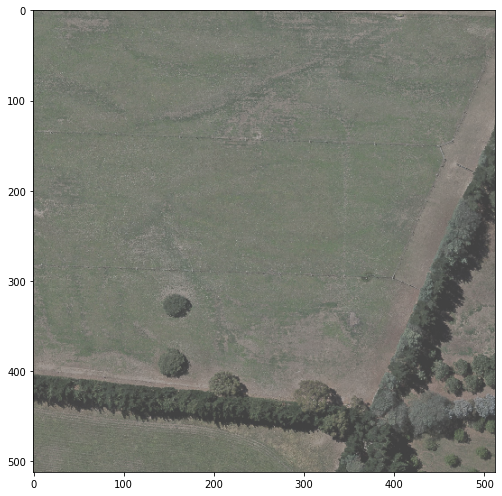

169it [01:16,  2.33it/s]

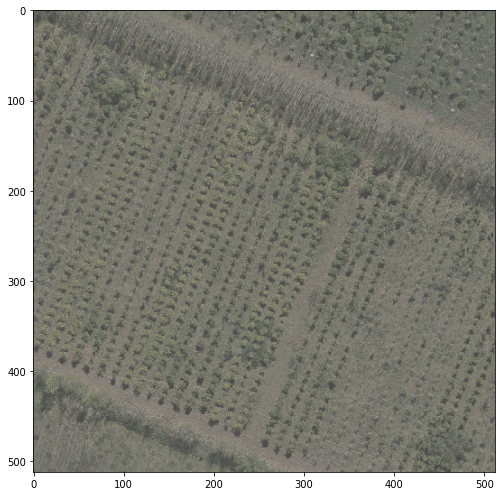

338it [02:30,  2.33it/s]

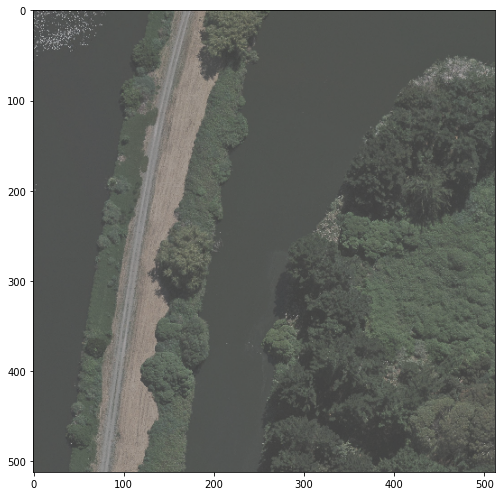

507it [03:43,  2.31it/s]

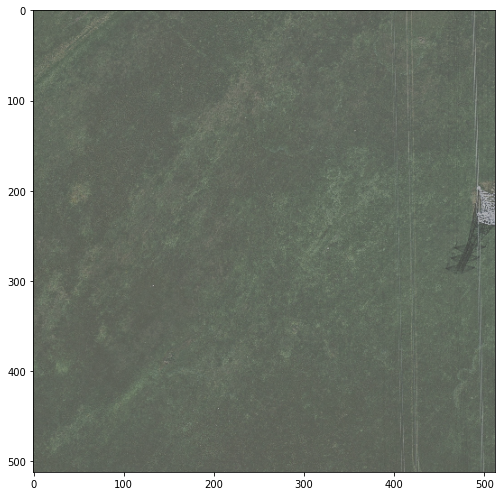

676it [04:57,  2.29it/s]

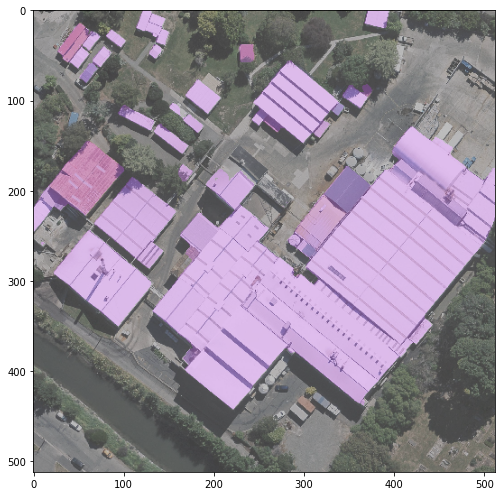

845it [06:11,  2.33it/s]

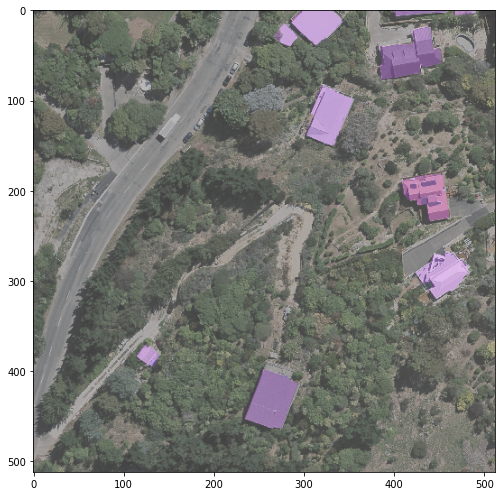

1014it [07:25,  2.26it/s]

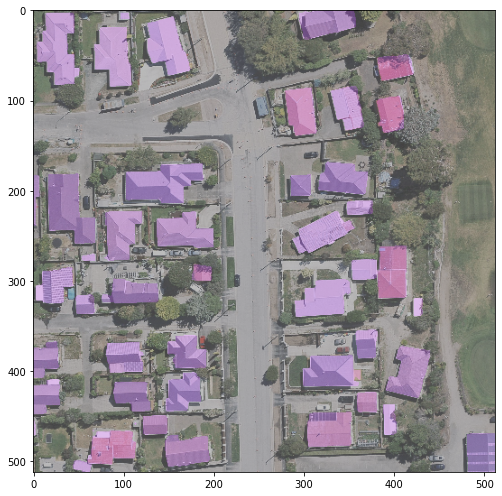

1183it [08:39,  2.30it/s]

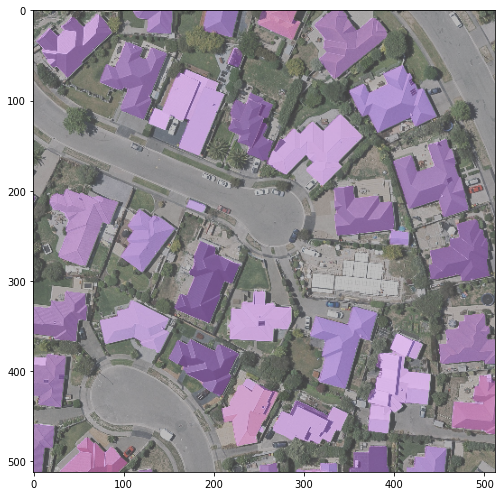

1352it [09:53,  2.32it/s]

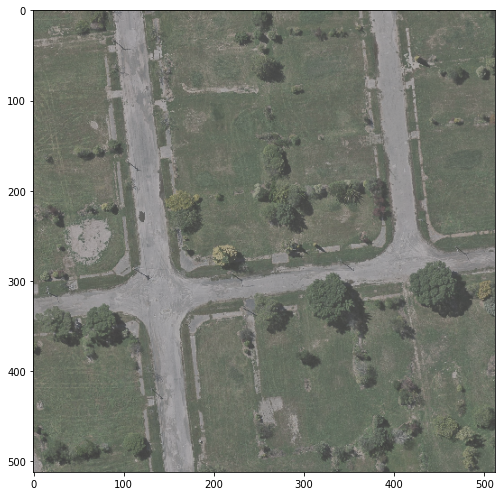

1521it [11:07,  2.28it/s]

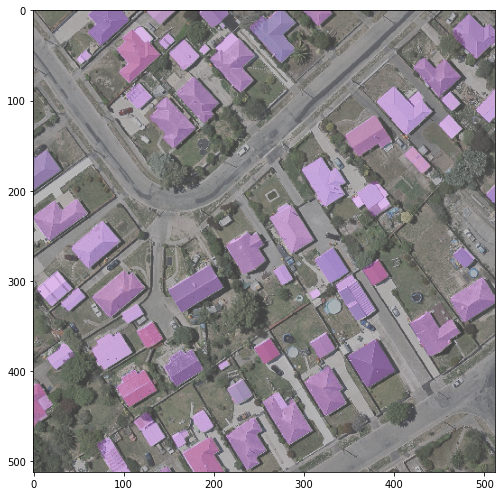

1690it [12:21,  2.29it/s]

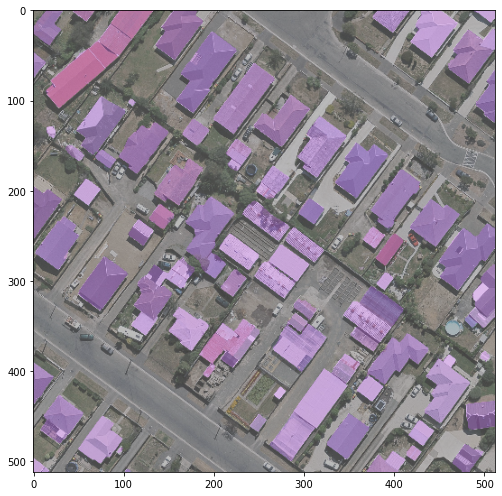

1859it [13:35,  2.35it/s]

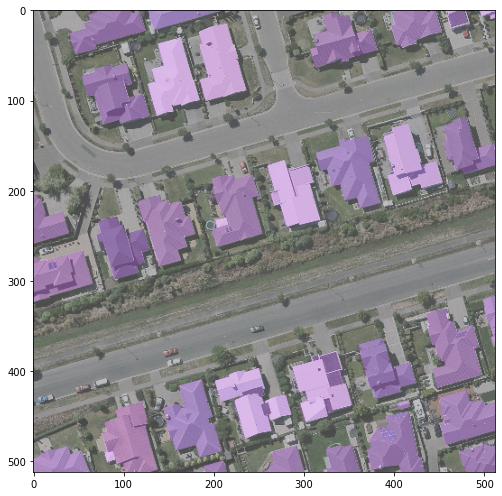

2028it [14:48,  2.29it/s]

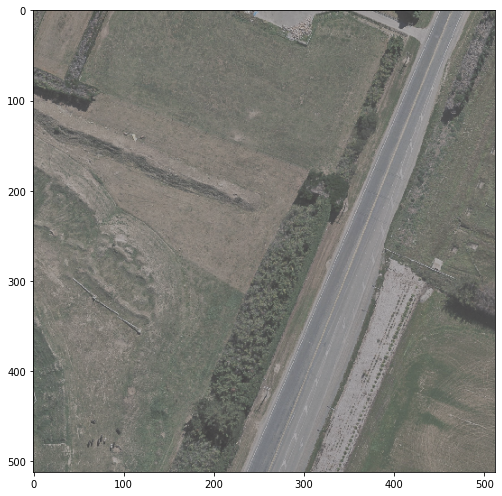

2197it [16:02,  2.28it/s]

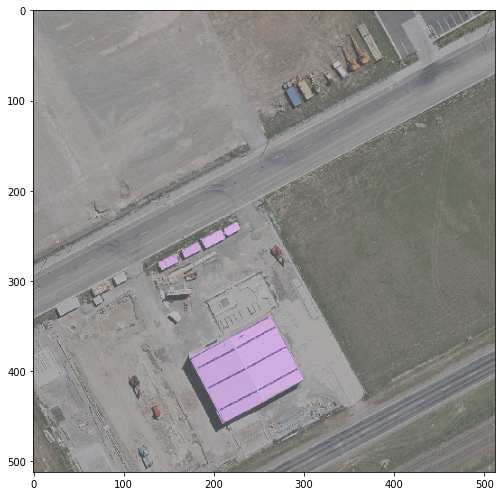

2366it [17:16,  2.32it/s]

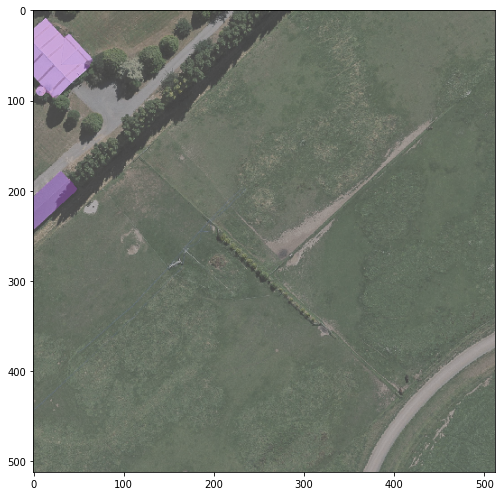

2416it [17:38,  2.28it/s]


prediction saved to ./summit.csv
一共有2416行


In [9]:
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')
# model.cfg = cfg
fnList, encodedPixelList = ["ID"], ["Prediction"]
for idx,i in tqdm(enumerate(testList)):
    img = mmcv.imread(i)
    result = inference_segmentor(model, img)
    
    pred = np.array(result).squeeze()
    fnList.append(imgNameList[idx])
    encodedPixelList.append(encodePixel(pred))

    if idx%int((len(testList)*0.07))==0:
        show_result_pyplot(model, img, result, palette=palette, fig_size=(11, 7), opacity=0.5)
        
make_summit_csv(fnList, encodedPixelList)